# Context
This notebook drives the training process for different models.

In [135]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [136]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [ ]:
def get_latest_file(folder_path):
  files = [f for f in os.listdir(folder_path) if "_" in f]
  latest = max(files)
  return os.path.join(folder_path, latest)

TRAIN_classes = "ten-classes"
scores_path = get_latest_file(
  os.path.join(sup.SCORES_ROOT, 
               TRAIN_classes,
               sup.TRAIN_BERT_CODE))

print(scores_path)

top_barrier=2

/Users/diego/Desktop/iteso/TOG/scores/ten-classes/BERT/archBERTanalysis-2025-06-15_22:54:24.csv


## Helper functions

In [138]:
import math

def significance(row, score_col):
  C = int(row["num_classes"])
  score = row[score_col]

  k = 2 if score_col == 'top2accuracy' else 1
  if C == k:
    return 0
  
  # Chance the true class appears in a random top-k set:
  # Choose (k - 1) other classes from the remaining (C - 1), then divide by all
  # possible top-k sets
  # chance_score = math.comb(C - 1, k - 1)  /  math.comb(C, k)
  #       "      = ((C-1)! / ((C-1-(k-1))! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / ((C-k)! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / (k-1)!)  /  (C! / k!)
  #       "      = ((C-1)! / C!)  /  ((k-1)! / k!)
  #       "      = (k! / (k-1)!) / (C! / (C-1)!)
  #       "      = k / C
  # So:
  chance_score = k / C

  if score_col == 'accuracy' or score_col == 'top2accuracy':
    std = math.sqrt(chance_score * (1 - chance_score) / 100 * C)
  elif score_col == 'macro_recall':
    std = math.sqrt((1 - chance_score) / (100 * C**2))
  elif score_col == 'macro_precision':
    std = math.sqrt((C - 1) / (100 * C**2))

  z = (score - chance_score)/std

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [140]:
def visualize(df: pd.DataFrame, group_cols, top, filter_cols=None, filter_values=None, sortby='accuracy'):
  """
  Optionally filters df by filter_cols == filter_values, groups by group_cols,
  selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
  """
  filter_desc = ""

  # Optional filtering
  if filter_cols and filter_values:
    for col, val in zip(filter_cols, filter_values):
      df = df[df[col] == val]
    filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

  if df.empty:
    print("Warning: DataFrame is empty after filtering.")
    return

  # Group + mean of top k
  def top_k_mean(g):
    top_k = g.sort_values(f'{sortby}', ascending=False).head(top)
    if top_k.empty:
      return float('nan')  # or 0.0
    return top_k[f'{sortby}'].mean()

  mean_accuracies = (
      df.groupby(group_cols)
        .apply(top_k_mean)
        .to_frame(f'mean_{sortby}')
        .reset_index()
  )

  if mean_accuracies.empty:
    print("Warning: No data to plot after grouping.")
    return

  # Create labels
  mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

  # Plotting
  colors = sns.color_palette("muted", len(mean_accuracies))
  plt.figure(figsize=(20, 12))
  plt.bar(mean_accuracies['label'], mean_accuracies[f'mean_{sortby}'], color=colors)

  plt.ylabel(f"Mean Accuracy (Top {top})")
  plt.title(f"Top {top} Mean {sortby} per {' + '.join(group_cols)}{filter_desc}")
  plt.xticks(rotation=45, ha='right')

  # Add y-limit padding
  min_val = mean_accuracies[f'mean_{sortby}'].min()
  max_val = mean_accuracies[f'mean_{sortby}'].max()
  padding = (max_val - min_val) * 0.3 if max_val > min_val else 0.1
  #plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

  # Add value labels
  for i, val in enumerate(mean_accuracies[f'mean_{sortby}']):
    plt.text(i, val + padding * 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()



In [141]:
def evolution(df, metric='accuracy_z', prep_cols=None):
  if prep_cols is None:
    prep_cols = []

  df = df.copy()

  # Use raw values to construct readable prep label
  def describe_prep(row):
    parts = [f"{col}={row[col]}" for col in prep_cols]
    return ' | '.join(parts)

  df['prep_label'] = df.apply(describe_prep, axis=1)

  prep_label_text = ', '.join(prep_cols) if prep_cols else 'no prep columns'

  # Plot
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=df, x='num_classes', y=metric, hue='prep_label', marker='o')
  plt.title(f'{metric} vs. Number of Classes by: {prep_label_text}')
  plt.xlabel('Number of Classes')
  plt.ylabel(metric)
  plt.grid(True)
  plt.tight_layout()
  plt.legend(title=f'Prep Strategy ({prep_label_text})', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()


## Data

In [142]:
scores_df = pd.read_csv(scores_path)
scores_df.sort_values(by="accuracy", ascending=False)

,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,batch_size,num_epochs,loadable,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
35,Spv,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,5760,gaunernst/bert-tiny-uncased,0.981043,0.981043,0.980530,0.982195,0.980476
39,Spv,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,384,distilbert-base-uncased,0.971564,0.995261,0.971491,0.971799,0.971602
36,Spv,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,2304,gaunernst/bert-mini-uncased,0.952607,0.976303,0.952946,0.954368,0.953182
15,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,1440,gaunernst/bert-tiny-uncased,0.936583,0.979390,0.937098,0.937999,0.936598
16,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,576,gaunernst/bert-mini-uncased,0.934205,0.971463,0.934915,0.936161,0.934315
17,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,192,gaunernst/bert-small-uncased,0.929845,0.971859,0.930130,0.931056,0.929946
19,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,96,distilbert-base-uncased,0.925882,0.972255,0.926309,0.926804,0.926032
38,Spv,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,576,gaunernst/bert-medium-uncased,0.919431,0.957346,0.920372,0.925845,0.920043
18,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,144,gaunernst/bert-medium-uncased,0.910028,0.963535,0.910148,0.912447,0.909822
37,Spv,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",False,False,NaN,NaN,72,1024,768,gaunernst/bert-small-uncased,0.909953,0.981043,0.910082,0.914824,0.910108


In [143]:
print(scores_df.columns.to_list())

['data_unit', 'class_list', 'difficulty', 'num_classes', 'class_name_list', 'PH2', 'PH3', 'reducer', 'kernel', 'num_components', 'batch_size', 'num_epochs', 'loadable', 'accuracy', 'top2accuracy', 'macro_f1', 'macro_precision', 'macro_recall']


In [144]:
for metric_name in ['accuracy', 'top2accuracy', 'macro_precision', 'macro_recall']:
  scores_df[f'{metric_name}_z'] = scores_df.apply(lambda x: significance(x, metric_name), axis=1)

scores_df['harmonic_z'] = scores_df.apply(harmonic_z, axis=1)

scores_df

,data_unit,class_list,difficulty,num_classes,class_name_list,PH2,PH3,reducer,kernel,num_components,...,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z,top2accuracy_z,macro_precision_z,macro_recall_z,harmonic_z
0,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,True,pca,NaN,9,...,0.699168,0.916369,0.698078,0.699697,0.700826,6.315782,5.663397,19.989904,63.332660,30.388258
1,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,True,pca,NaN,9,...,0.748712,0.919540,0.745500,0.750315,0.751085,6.838023,5.688465,21.677181,68.630375,32.947698
2,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,True,pca,NaN,9,...,0.678954,0.888228,0.677087,0.679494,0.681133,6.102707,5.440922,19.316466,61.256747,29.371148
3,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,True,pca,NaN,9,...,0.661910,0.861276,0.652254,0.674878,0.666216,5.923056,5.227848,19.162610,59.684406,29.010838
4,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,True,pca,NaN,9,...,0.657154,0.876734,0.655681,0.656895,0.658259,5.872921,5.350052,18.563173,58.845631,28.223188
5,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,False,NaN,NaN,75,...,0.837099,0.957987,0.835442,0.835169,0.837040,7.769702,5.992410,24.505631,77.690813,37.258878
6,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,False,NaN,NaN,75,...,0.805787,0.954816,0.800344,0.807379,0.807717,7.439646,5.967342,23.579298,74.599908,35.832709
7,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,False,NaN,NaN,75,...,0.734047,0.926278,0.730193,0.734904,0.736627,6.683440,5.741734,21.163477,67.106386,32.178694
8,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,False,NaN,NaN,75,...,0.615933,0.848989,0.601220,0.618513,0.620155,5.438416,5.130711,17.283771,54.829173,26.282518
9,Spf,ten-classes,unspecified,10,"['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', ...",True,False,NaN,NaN,75,...,0.732461,0.907253,0.729490,0.738355,0.733896,6.666728,5.591328,21.278483,66.818478,32.277978


### Inital number-of-classes-agnostic analysis

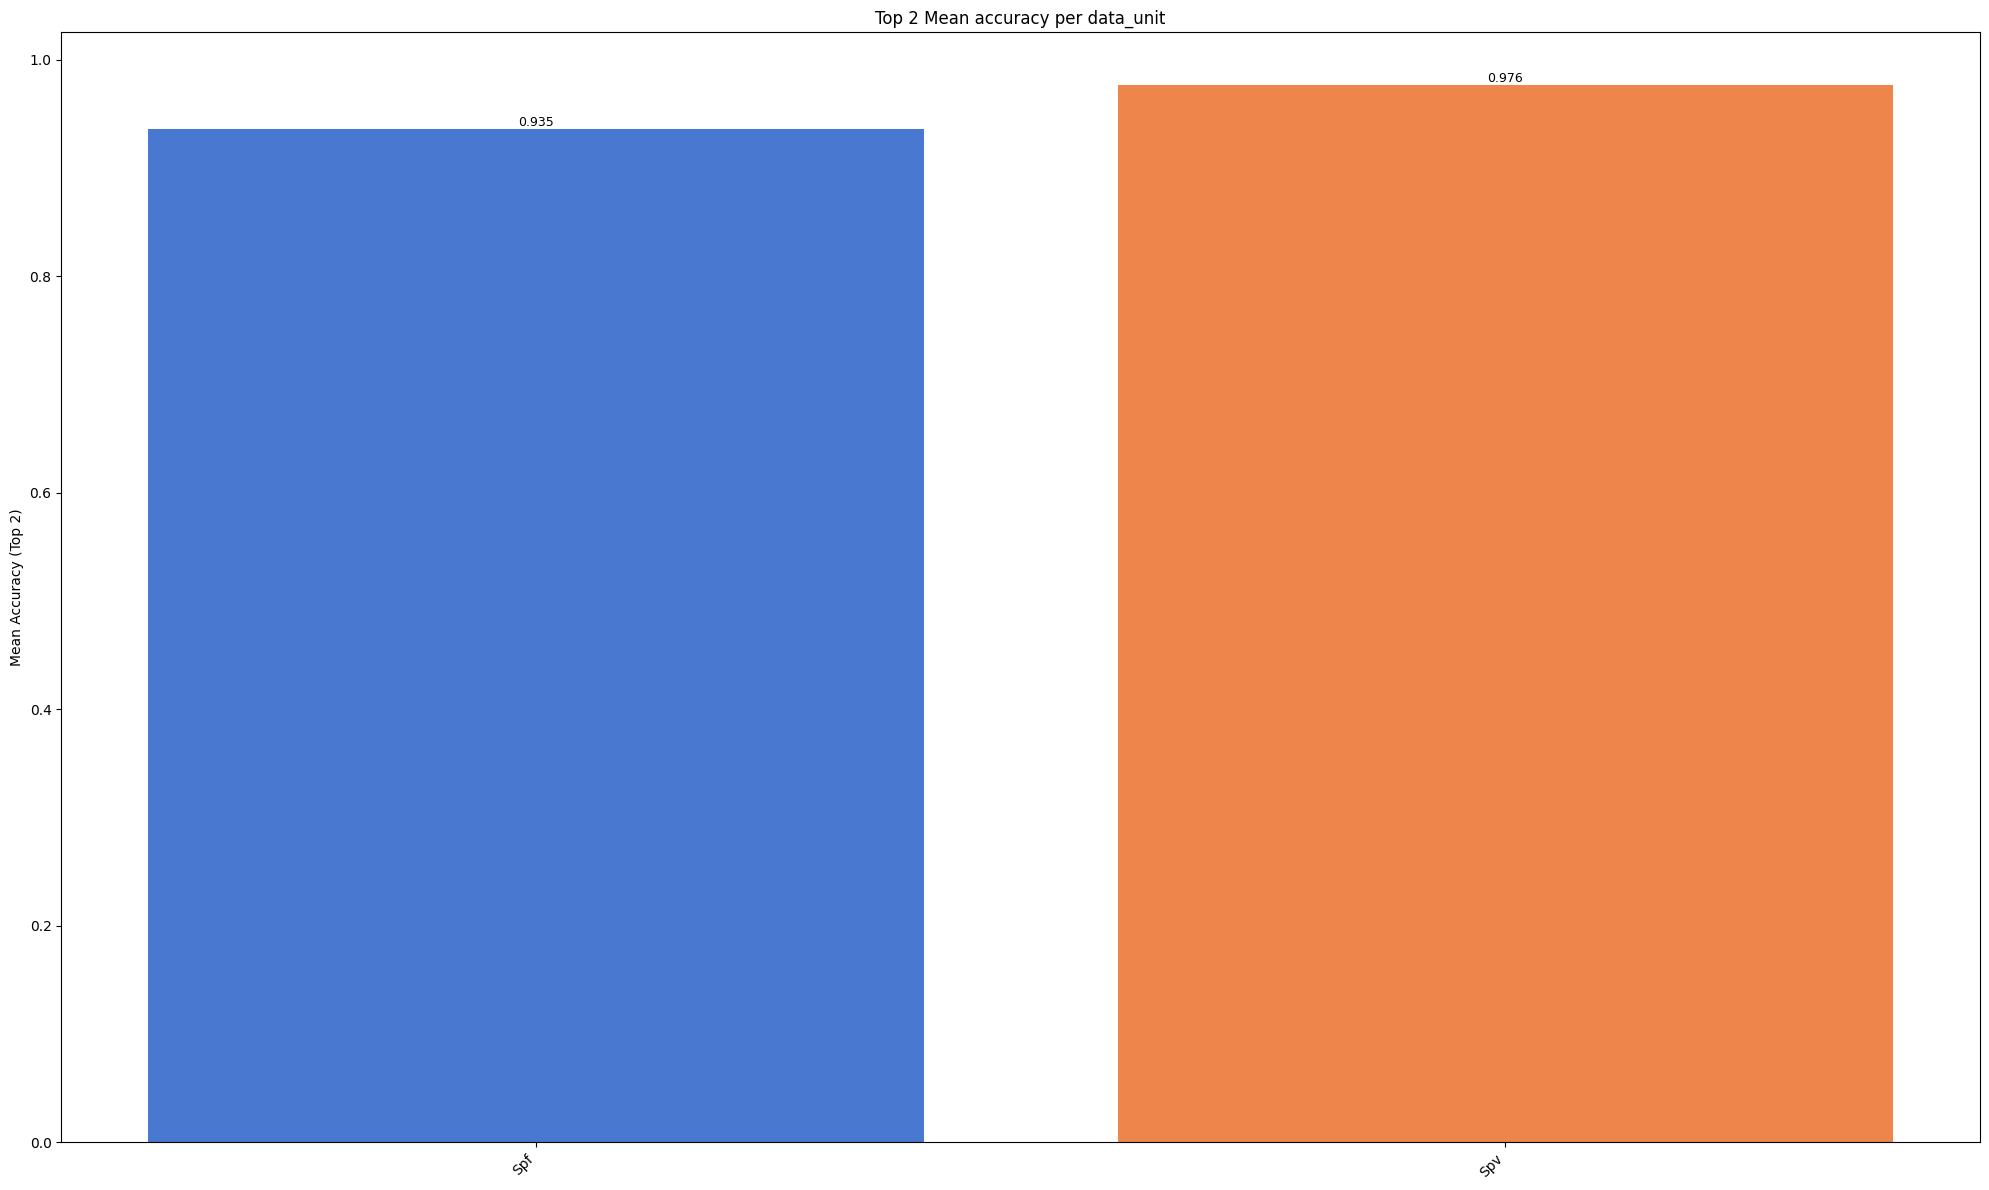

In [145]:
visualize(scores_df, group_cols=['data_unit'], top=top_barrier)

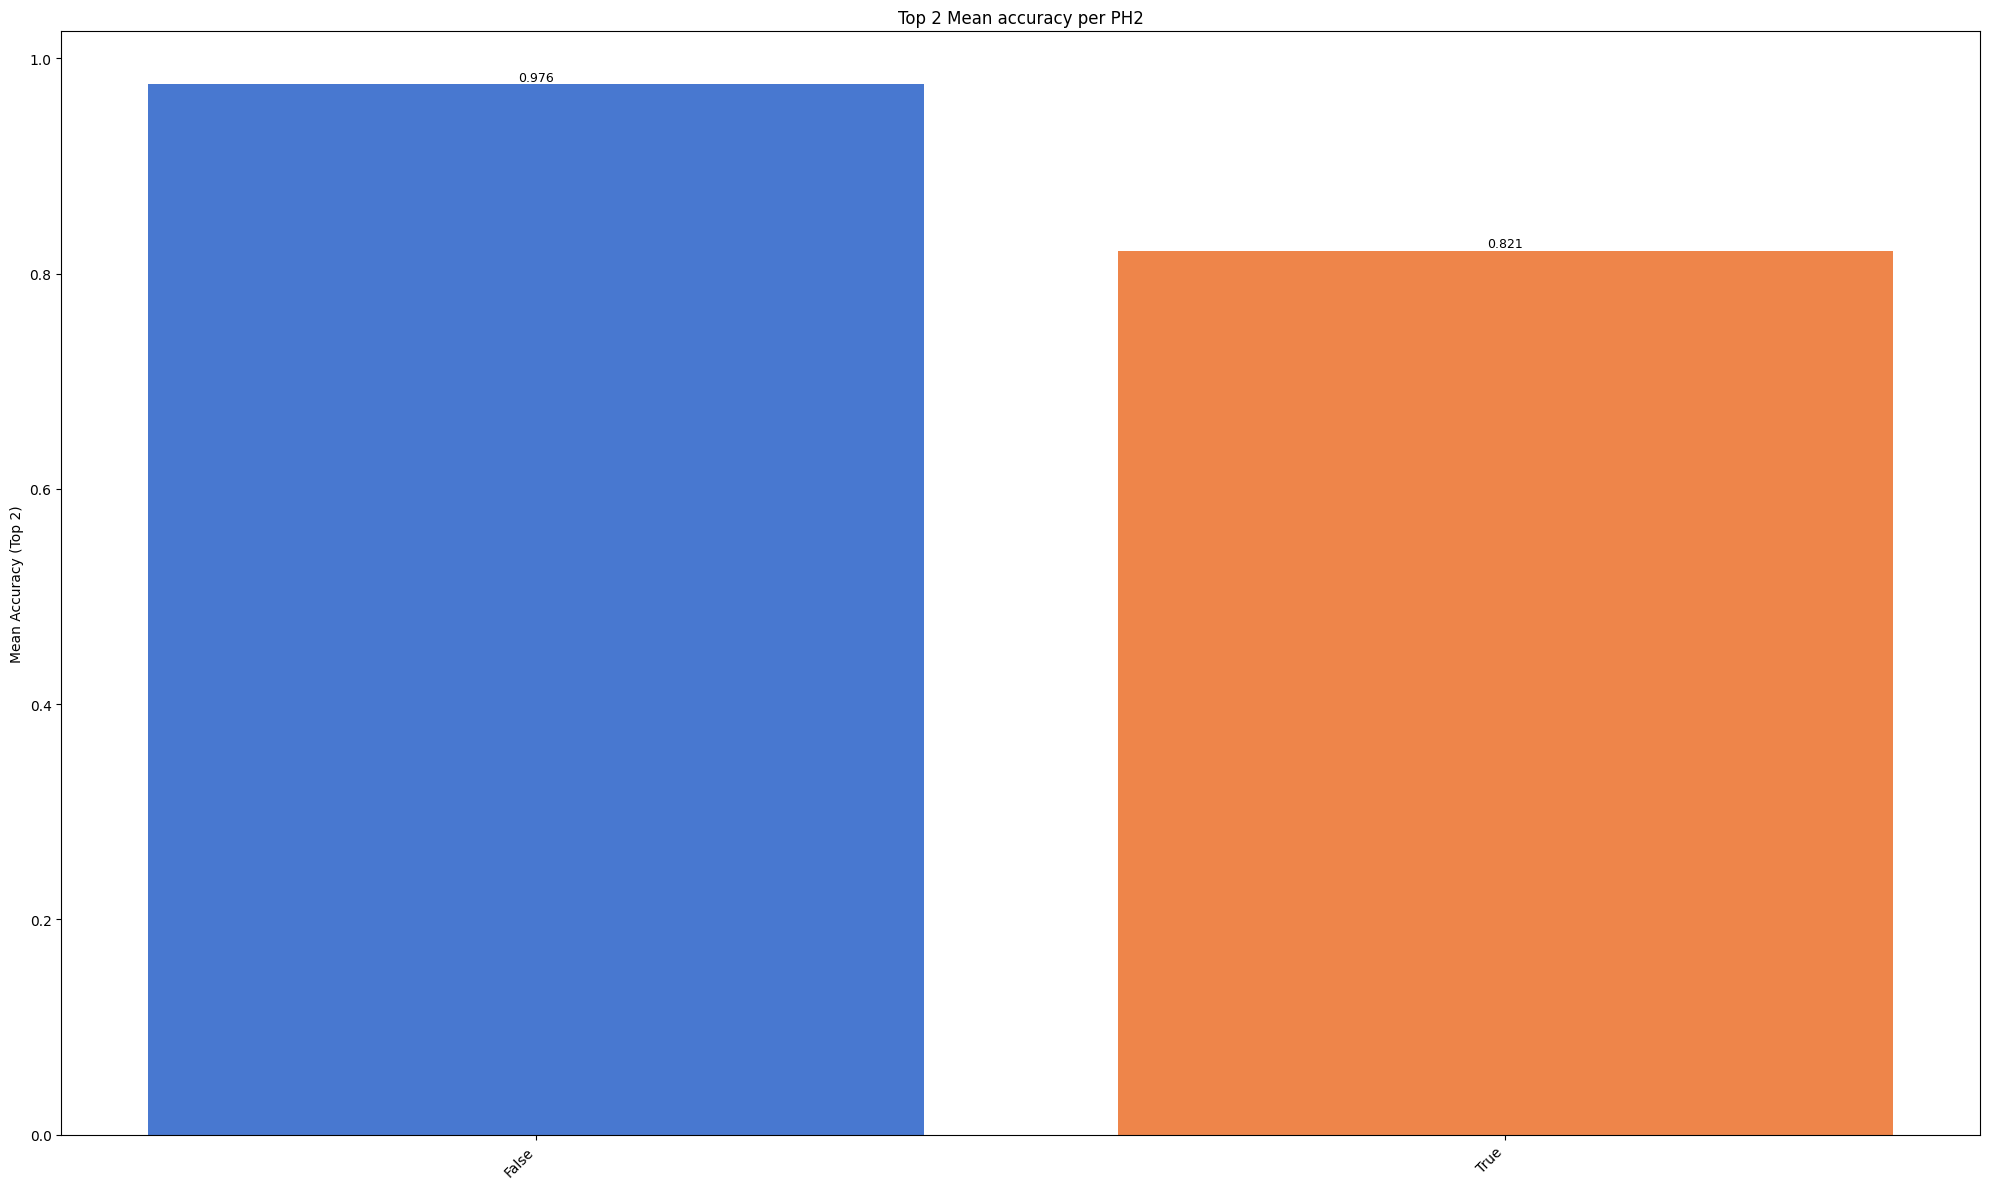

In [146]:
visualize(scores_df, group_cols=['PH2'], top=top_barrier)

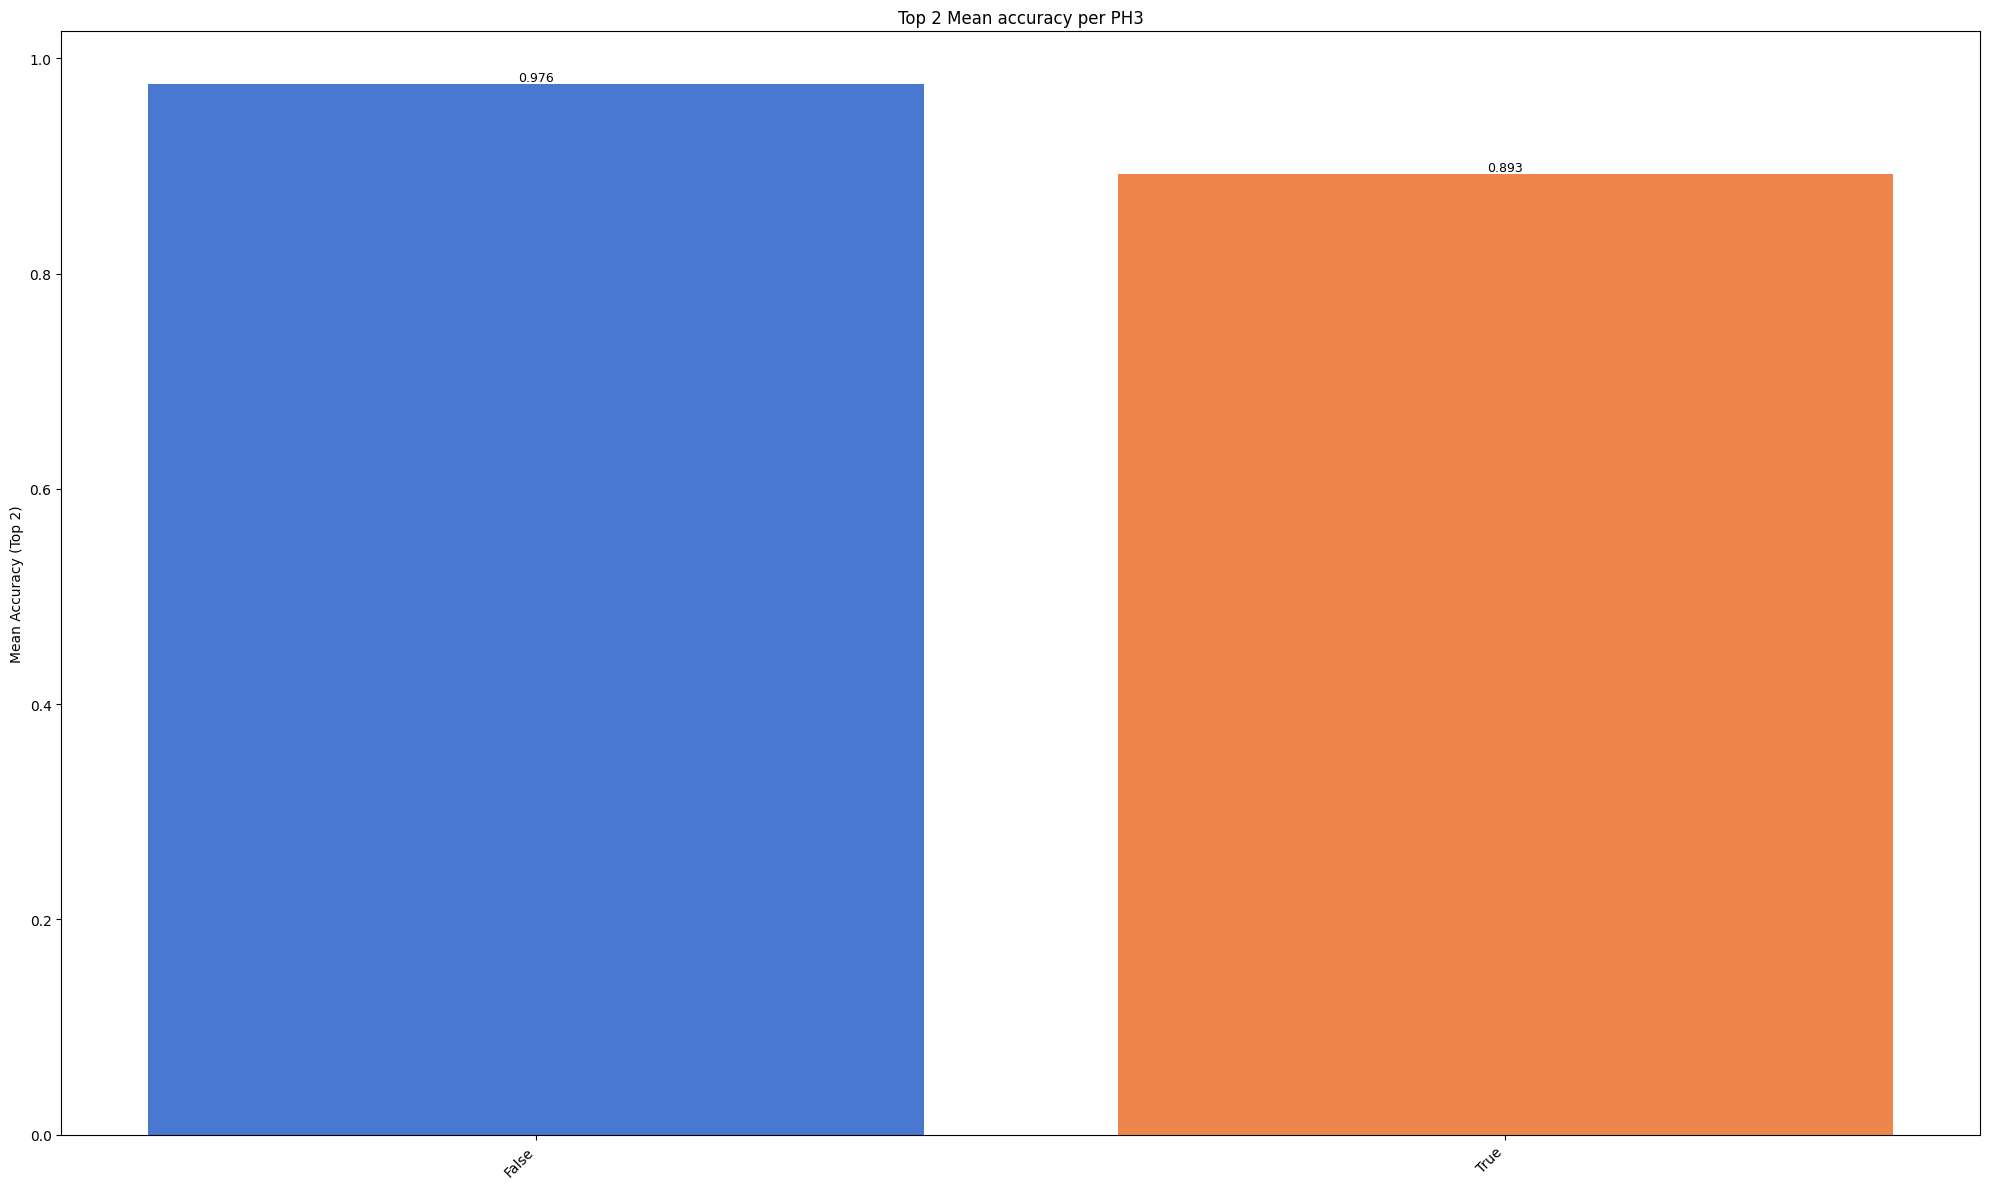

In [147]:
visualize(scores_df, group_cols=['PH3'], top=top_barrier)

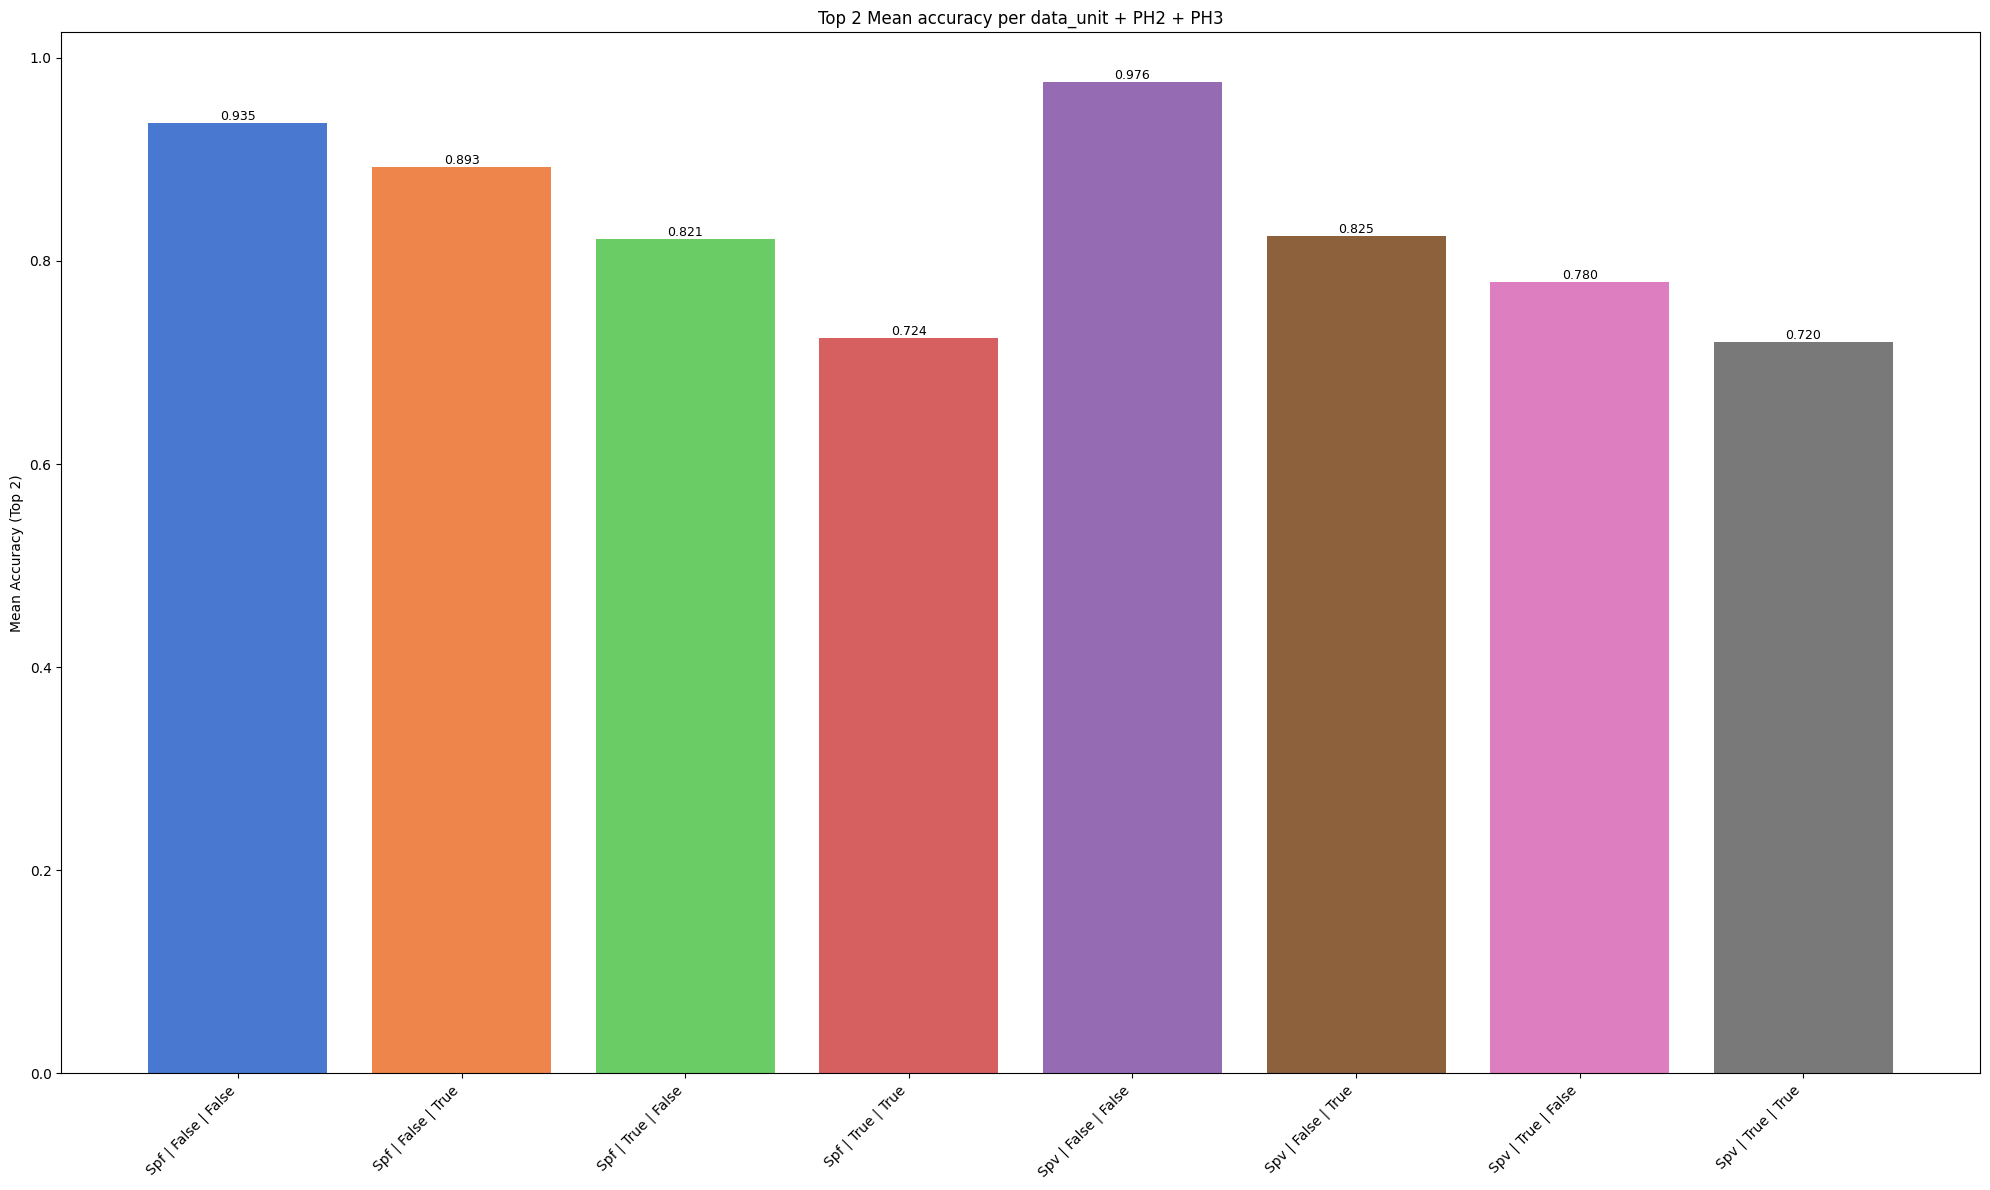

In [148]:
visualize(scores_df, group_cols=['data_unit','PH2', 'PH3'], top=top_barrier)

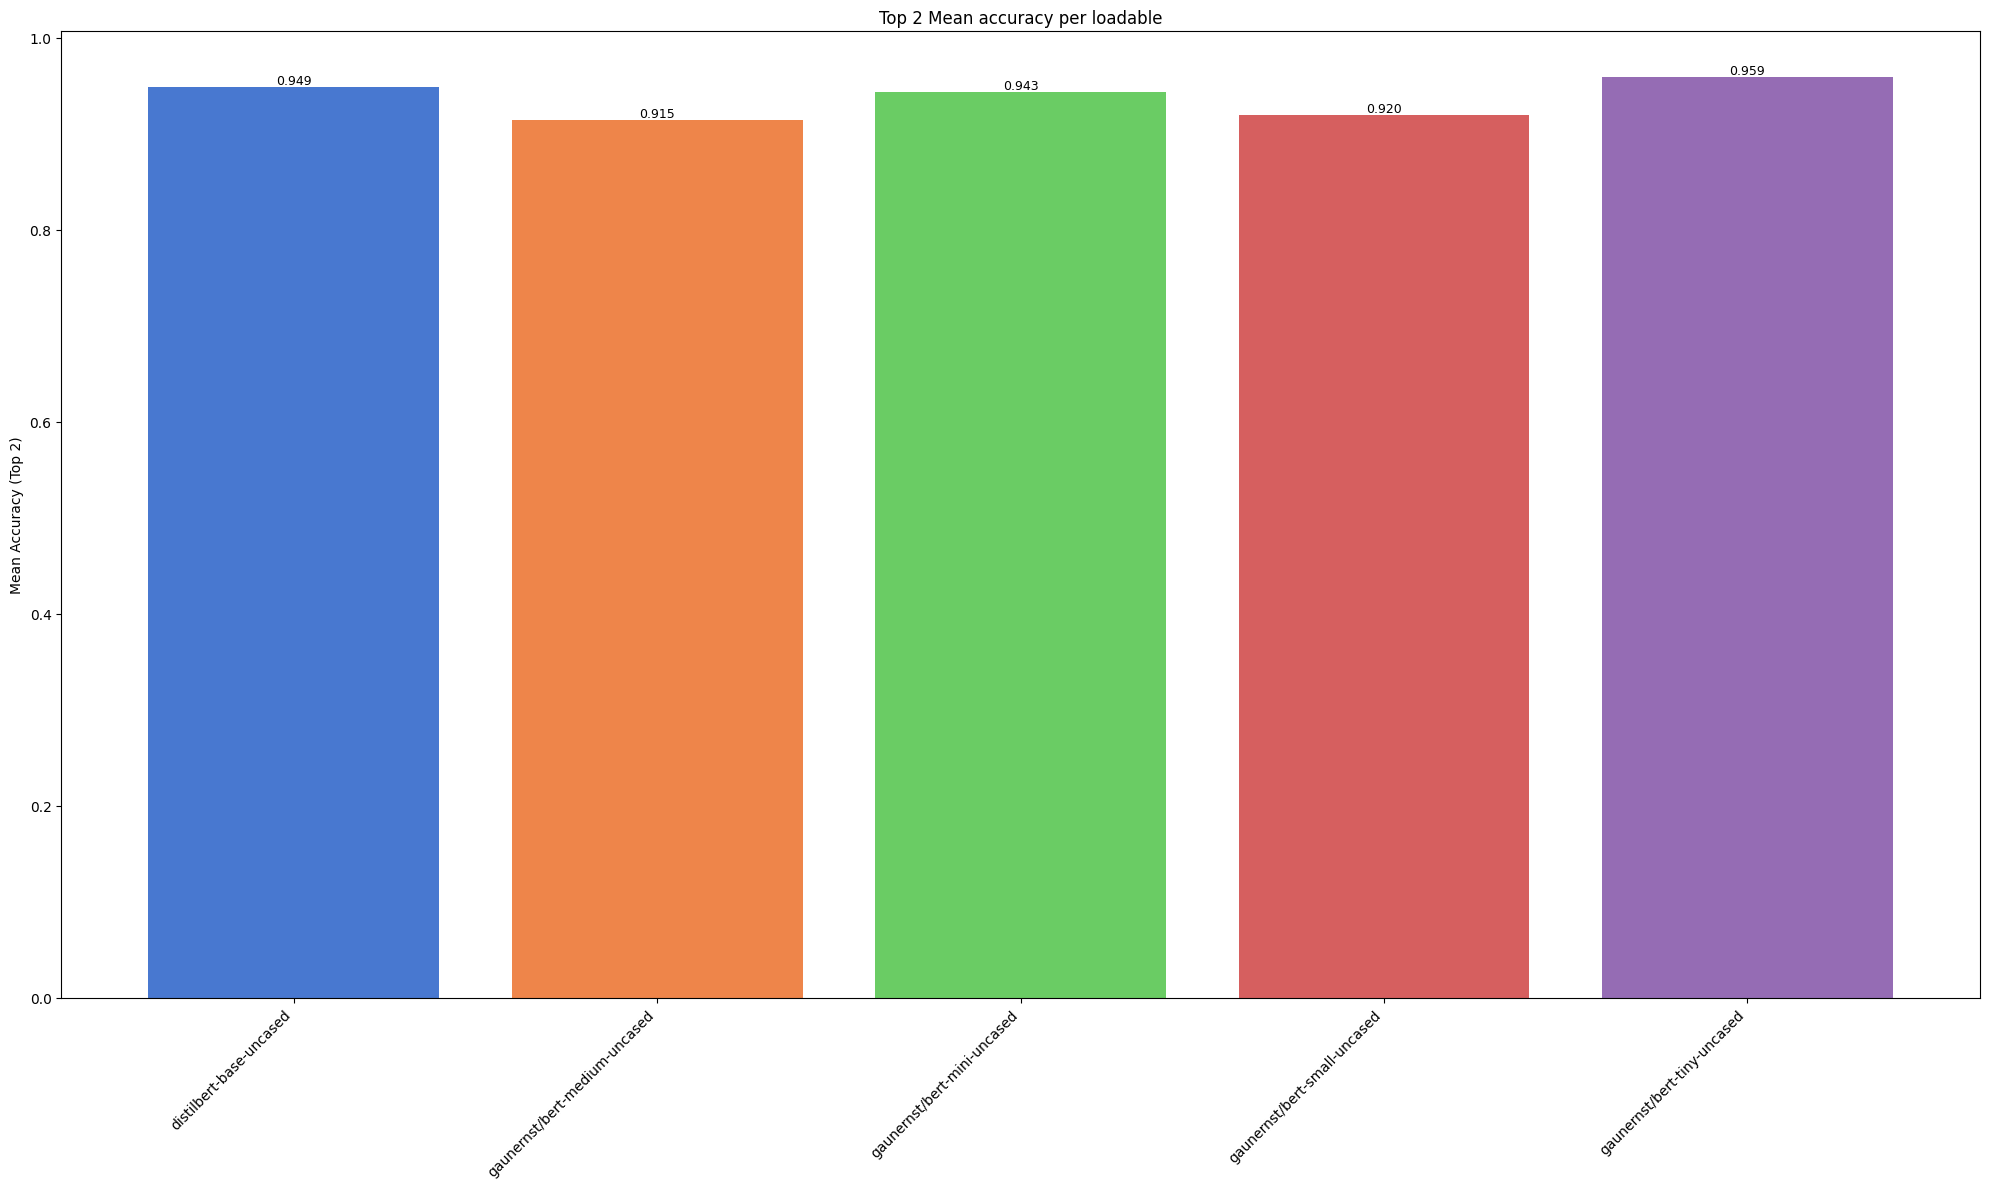

In [149]:
visualize(scores_df, group_cols=['loadable'], top=top_barrier)

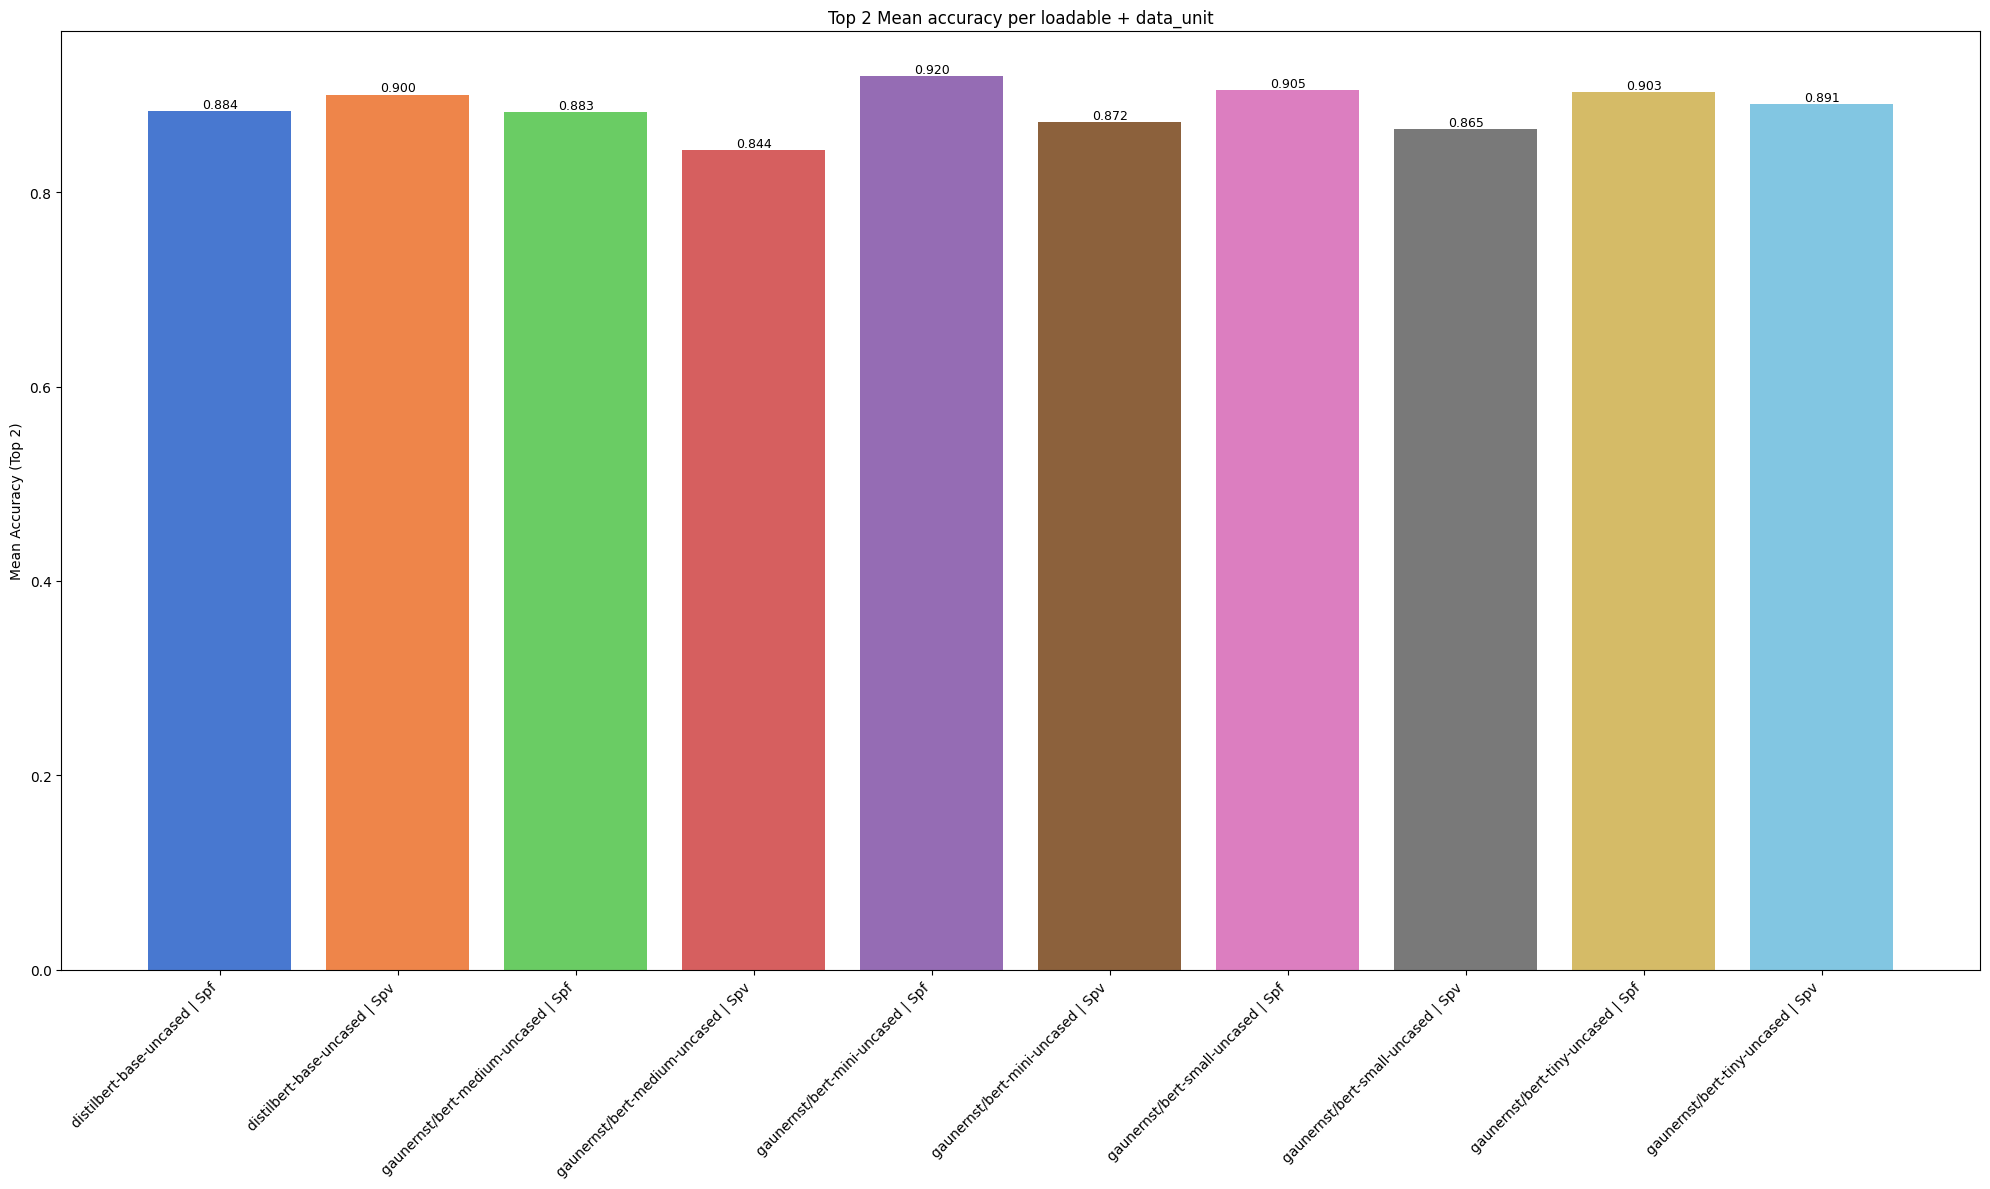

In [150]:
visualize(scores_df, group_cols=['loadable', 'data_unit'], top=top_barrier)